# Normalising flows with Pyro

In [2]:
import torch
import pyro #pyro is new
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
from pyro.nn import AutoRegressiveNN
import seaborn as sns #seaborn is new
import os
smoke_test = ('CI' in os.environ) #this part is unnecessary and can be ignored

plt.rcParams['figure.figsize'] = [10,10] #this changes the default plot size to 10 by 10 for all figures in the notebook

In [3]:
#this function plots the loss from the stochastic gradient descent along with a smoothed running average

def plot_loss(loss_vec,n = 10,y_upper = 5):
    loss_vec_np = loss_vec.detach().numpy()
    count_array = np.arange(loss_vec_np.size) + 1
    
    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    mov_average = moving_average(loss_vec_np,n)
    
    plt.plot(count_array,loss_vec_np)
    plt.plot(count_array[:-n+1],mov_average)

    #plt.ylim(0,y_upper)

## Basic Pyro implementation
This is performing density estimation from the following ```sklearn``` ```make_circles``` dataset using KL-divergence as the loss function.

In [5]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2)) #this defines the base normal distribution
spline_transform = T.spline_coupling(2, count_bins=16) #this defines the parameterised transform

flow_dist = dist.TransformedDistribution(base_dist, [spline_transform]) 
#a flow object is a distribution defined as the transformation of the base distribution through the given transform
#if you change the parameters in spline_transform, then the distribution of flow_dist will change too

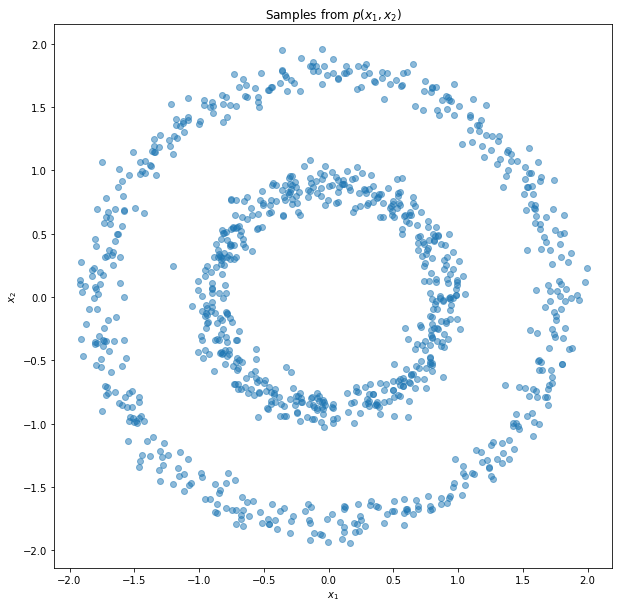

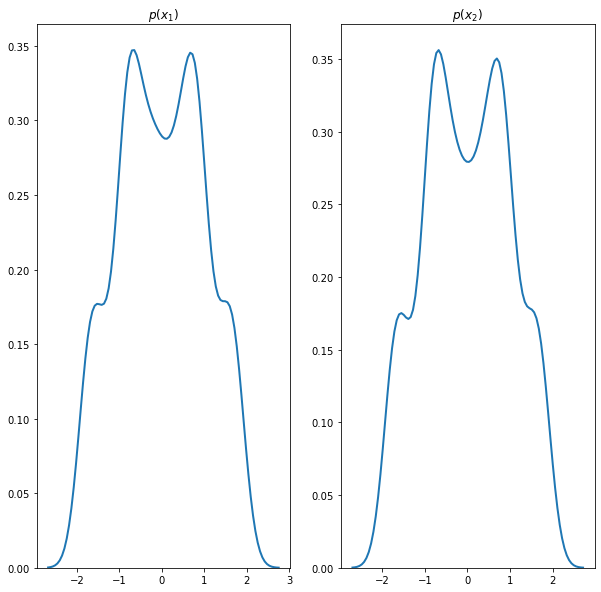

In [6]:

import numpy as np
from sklearn import datasets #we get the data from sklearn's datasets module
from sklearn.preprocessing import StandardScaler 

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05) #this loads in the data
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1) #the following plots use seaborn
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [12]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float) #we have to turn the data into a tensor object so pytorch can work on it

#the following defines the Adam optimiser, note the parameters it optimises over are spline_transform's
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3) 

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean() #this is the loss function 
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 5.086073875427246
step: 500, loss: 1.8741137981414795
step: 1000, loss: 1.753391146659851
step: 1500, loss: 1.7972506284713745
step: 2000, loss: 1.7173573970794678
step: 2500, loss: 2.4772205352783203
step: 3000, loss: 1.7436109781265259
step: 3500, loss: 1.706949234008789
step: 4000, loss: 1.6576976776123047
step: 4500, loss: 1.6104437112808228
step: 5000, loss: 1.617681622505188
Wall time: 57.5 s


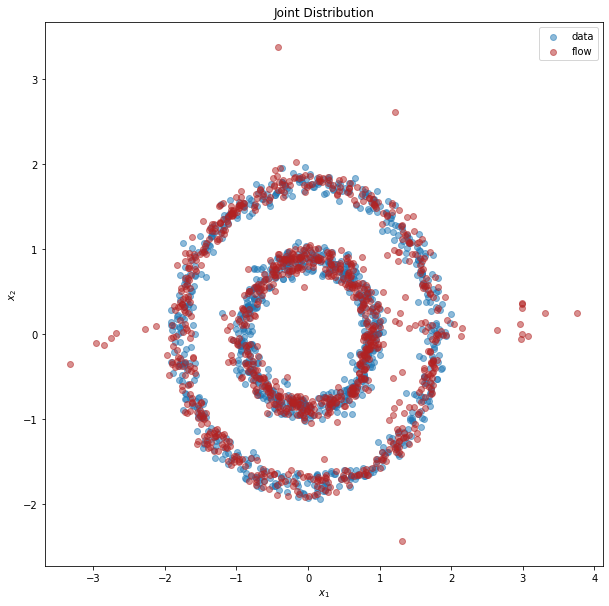

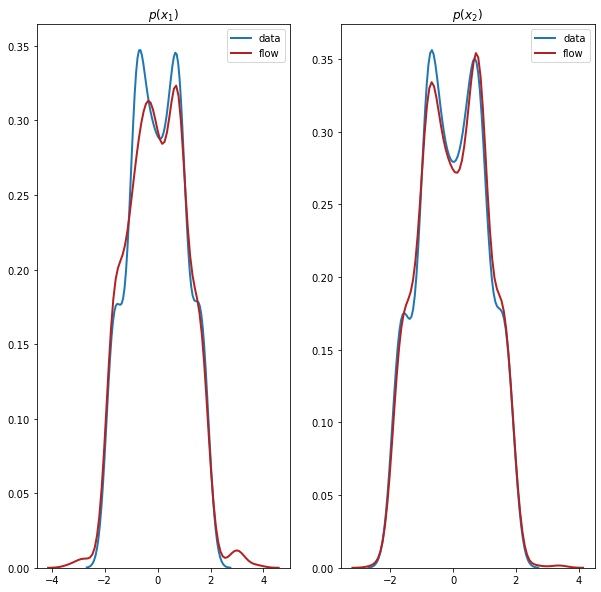

In [13]:

X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

## Defining KSD loss function 
We now move on to using KSD instead of KL-divergence and use it in variational inference settings.

In [15]:
import torch.nn as nn

l2 = nn.PairwiseDistance(2) #this function l2 computes all the pairwise distances between each component of a tensor 

def loss_KSD(samples, score_func, gamma=1):
    N = samples.size()[0]
    d = samples[0].size()[0] #dimension of tensor
    g = 1/gamma
        
    scores = score_func(samples)
    s1 = scores.repeat(1,N).view(N*N,2) 
    s2 = scores.repeat(N,1)
    
    samps1 = samples.repeat(1,N).view(N*N,2)
    samps2 = samples.repeat(N,1)

    diffs = samps1 - samps2
    dists = l2(samps1,samps2)**2

    k = (1 + g*dists)**(-1/2)
    k_x = -g*(1 + g*dists[:,None])**(-3/2)*diffs
    k_y = -k_x
    k_xy = -3 * g**2 * dists*(1 + g*dists)**(-5/2) + g*d*(1 + g*dists)**(-3/2)
    
    outvec = k*torch.sum(s1*s2,dim=-1) + torch.sum(s1*k_y,dim=-1) + torch.sum(s2*k_x,dim=-1) + k_xy
    output = torch.mean(outvec)
    
    return output

## Defining test score functions
We now define the toy test functions we are going to use

### Standard Normal

In [16]:
def score_standard_norm(x):
    return -x

### Mixture of Gaussians

In [18]:
def score_mixture_gauss(x, MOG):

    p_0 = torch.exp(MOG[0].log_prob(x))
    x_0 = -(x - MOG[0].mean)

    output = x_0 * p_0[:,None]
    
    for i in range(len(MOG)-1):
        p_i = torch.exp(MOG[i+1].log_prob(x))
        x_i = - (x - MOG[i+1].mean)
        output = output + x_i * p_i[:,None]
        p_0 = p_0 + p_i
        
    output = output / p_0[:, None]
    return output

In [19]:
m1 = torch.Tensor([2,2])
g1 = torch.distributions.multivariate_normal.MultivariateNormal(m1,torch.eye(2))

m2 = torch.Tensor([0,-1])
g2 = torch.distributions.multivariate_normal.MultivariateNormal(m2,torch.eye(2))

MOG_example = [g1,g2]

score_mix_example = lambda x: score_mixture_gauss(x,MOG_example)

In [20]:
def plot_MOG(MOG):
    xline = torch.linspace(-5, 5)
    yline = torch.linspace(-5, 5)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        n = len(MOG)
        zgrid = 1/n*MOG[0].log_prob(xyinput).exp().reshape(100, 100)
        for i in range(n-1):
            zgrid = zgrid + 1/n*MOG[i+1].log_prob(xyinput).exp().reshape(100, 100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())

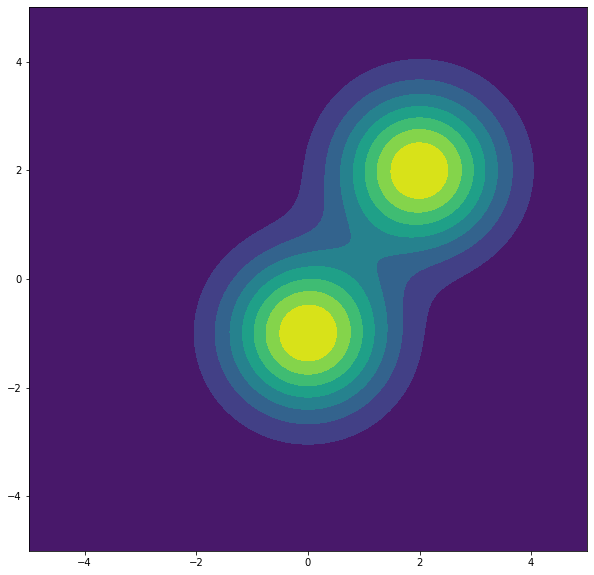

In [21]:
plot_MOG(MOG_example)

### 2D Banana 
Banana density of the form

$$ p(x_1,x_2) = \mathcal{N}(x_1;0,v_1^2)\mathcal{N}(x_2;ax_1^2,v_2^2), $$

where $\mathcal{N}(x;\mu,\sigma^2)$ is one-dimensional Gaussian distribution with mean $\mu$ and variance $\sigma^2$.

In [22]:
def score_banana(x,a,v1,v2):
    x1,x2 = x.t()
    dx1 = -x1/v1 + 2*a*x1*(x2-a*x1**2)/v2
    dx2 = -(x2-a*x1**2)/v2
    return torch.stack((dx1,dx2)).t()

In [34]:
def plot_banana(a,v1,v2,n_levs=8,s = 8):
    xline = torch.linspace(-s, s)
    yline = torch.linspace(-s, s)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        n = np.pi*2*v1*v2
        out1 = xyinput*torch.Tensor([[1,0]])
        out2 = xyinput*torch.Tensor([[0,1]])
        zgrid = 1/n*torch.exp(-(1/2)*(torch.sum(out1**2,dim=-1)/(v1 ** 2) + torch.sum(out2-a*out1**2,dim=-1)**2 / (v2 ** 2))).reshape(100,100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy(),levels = n_levs)

In [26]:
from torch.distributions.multivariate_normal import MultivariateNormal

def sample_banana(n,a,v1,v2):
    MN = MultivariateNormal(torch.Tensor([0,0]),torch.eye(2))
    samp = MN.sample(torch.Size([n,]))
    sampt = samp.t()
    sampt[0] = sampt[0] * v1
    sampt[1] = sampt[1]*(v2) + a * sampt[0].pow(2)
    return sampt.t()
    

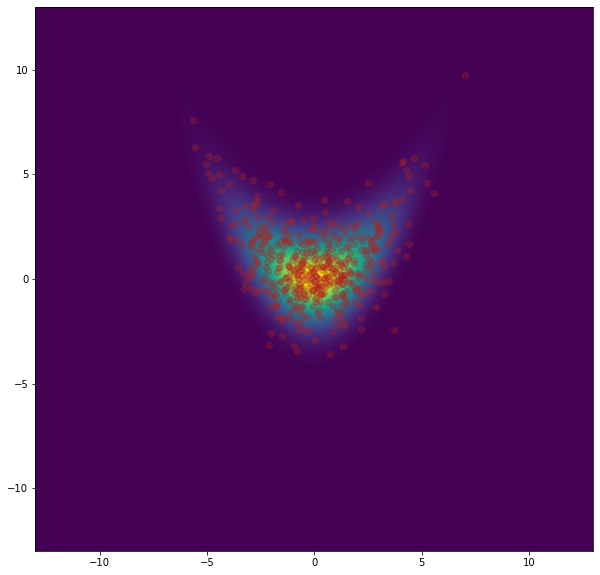

In [38]:
a = 0.2
v1 = 2
v2 = 1.3

samps_np = sample_banana(500,a,v1,v2).numpy()
plot_banana(a,v1,v2,1000,13)
plt.scatter(np.transpose(samps_np)[0],np.transpose(samps_np)[1],color='firebrick',alpha=0.3)

### 2D Sinusoidal 

Sinusoidal density of the form

$$ p(x_1,x_2) = \mathcal{N}(x_1;0,v_1)\mathcal{N}(x_2;\sin(a x_1),v_2), $$

where $\mathcal{N}(x;\mu,\sigma^2)$ is one-dimensional Gaussian distribution with mean $\mu$ and variance $\sigma^2$.

In [39]:
def score_sinusoidal(x,a,v1,v2):
    x1,x2 = x.t()
    dx1 = -x1/v1 + a*torch.cos(a*x1)*(x2-torch.sin(a*x1))/v2
    dx2 = -(x2-torch.sin(a*x1))/v2
    return torch.stack((dx1,dx2)).t()

In [40]:
def sample_sinusoidal(n,a,v1,v2):
    MN = MultivariateNormal(torch.Tensor([0,0]),torch.eye(2))
    samp = MN.sample(torch.Size([n,]))
    sampt = samp.t()
    sampt[0] = sampt[0] * v1
    sampt[1] = sampt[1] * v2 + torch.sin(a * sampt[0])
    return sampt.t()

In [41]:
def plot_sinusoidal(a,v1,v2,n_levels=10):
    xline = torch.linspace(-8, 8)
    yline = torch.linspace(-8, 8)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        n = np.pi*2*v1*v2
        out1 = xyinput*torch.Tensor([[1,0]])
        out2 = xyinput*torch.Tensor([[0,1]])
        zgrid = 1/n*torch.exp(-(1/2)*(torch.sum(out1**2,dim=-1)/(v1 ** 2) + torch.sum(out2-torch.sin(a*out1),dim=-1)**2 /(v2 ** 2))).reshape(100,100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy(),levels = n_levels)

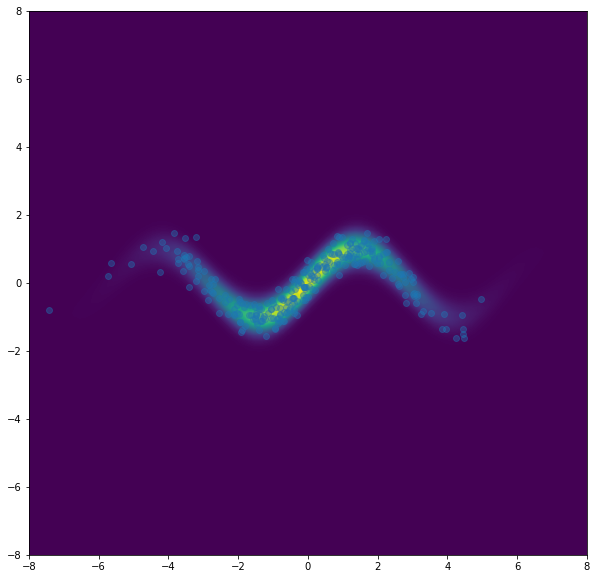

In [44]:
a = 1.1
v1 = 2
v2 = 0.3

plot_sinusoidal(a,v1,v2,1000)
samps_np = sample_sinusoidal(300,a,v1,v2).numpy()
plt.scatter(np.transpose(samps_np)[0],np.transpose(samps_np)[1],alpha=0.4)

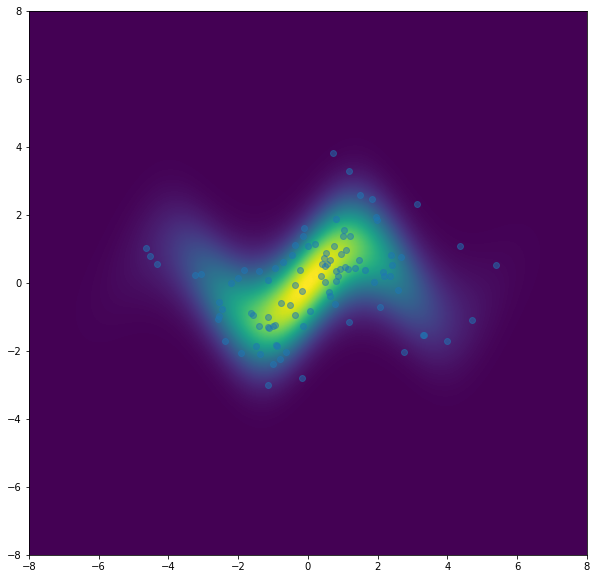

In [45]:
a = 1.1
v1 = 2
v2 = 1

plot_sinusoidal(a,v1,v2,1000)
samps_np = sample_sinusoidal(100,a,v1,v2).numpy()
plt.scatter(np.transpose(samps_np)[0],np.transpose(samps_np)[1],alpha=0.5)

## Variational inference with KSD
We now start doing experiments

### Banana density

In [58]:
a = 0.3
v1 = 1.4
v2 = 0.4
banana_test = lambda x: score_banana(x,a,v1,v2)

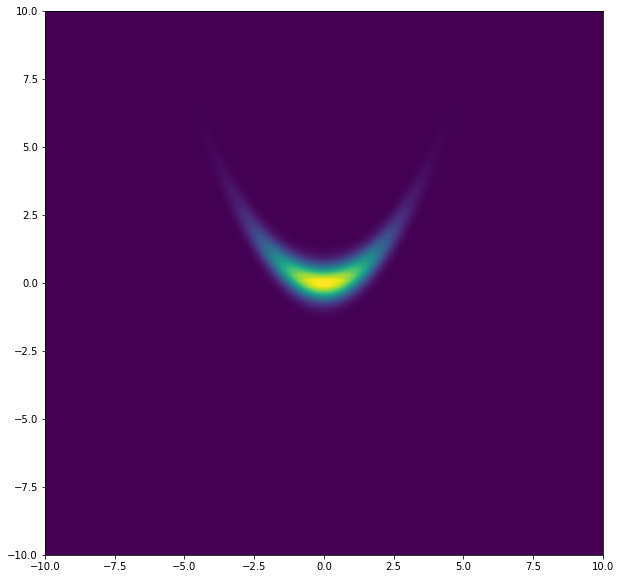

In [59]:
plot_banana(a,v1,v2,1000,10)

The following two cells define possible transport maps you could use. Look at their corresponding documentations for more details here http://docs.pyro.ai/en/stable/distributions.html?highlight=transforms#transforms. To use each one just run the corresponding cell before starting the optimisation procedure.

In [51]:
from pyro.nn import AutoRegressiveNN

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

input_dim = 2
count_degree = 2
count_sum = 7
param_dims = [(count_degree + 1)*count_sum]

arn = AutoRegressiveNN(input_dim, [input_dim*10], param_dims)

transform = T.Polynomial(arn, input_dim=input_dim, count_degree=count_degree,count_sum=count_sum)
flow_dist = dist.TransformedDistribution(base_dist, [transform])


In [60]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
transform = T.AffineAutoregressive(AutoRegressiveNN(2, [60]))
flow_dist = dist.TransformedDistribution(base_dist, [transform])

iteration: 500, loss: tensor(0.0472, grad_fn=<MeanBackward0>)


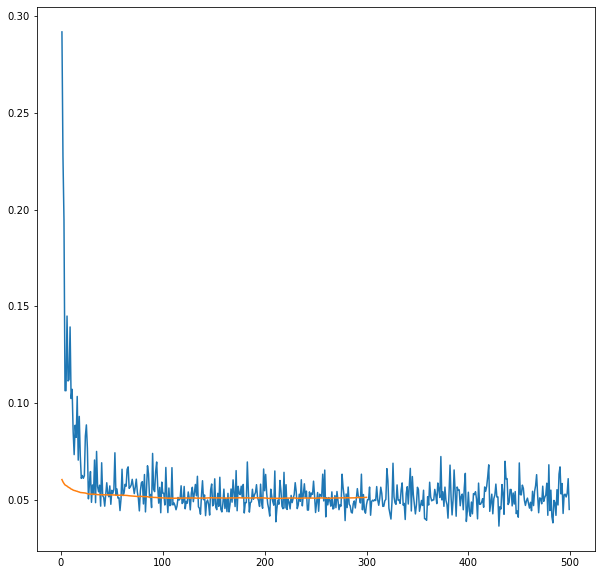

iteration: 1000, loss: tensor(0.0563, grad_fn=<MeanBackward0>)


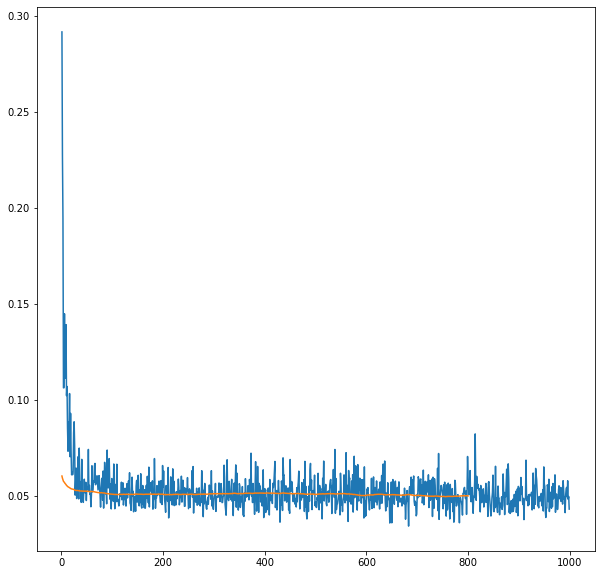

iteration: 1500, loss: tensor(0.0515, grad_fn=<MeanBackward0>)


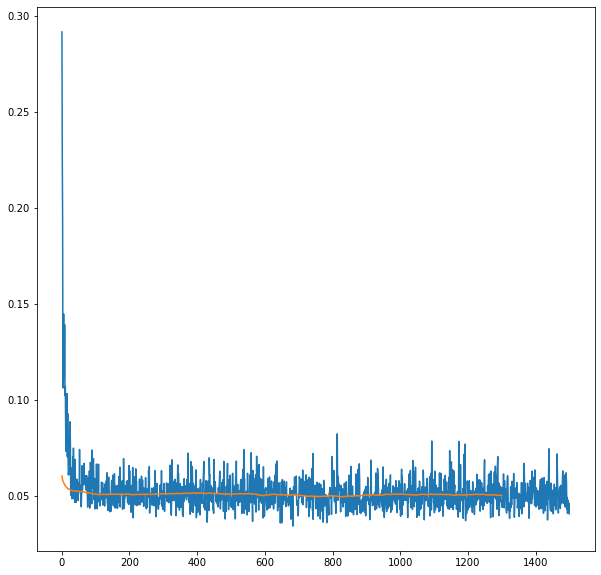

iteration: 2000, loss: tensor(0.0499, grad_fn=<MeanBackward0>)


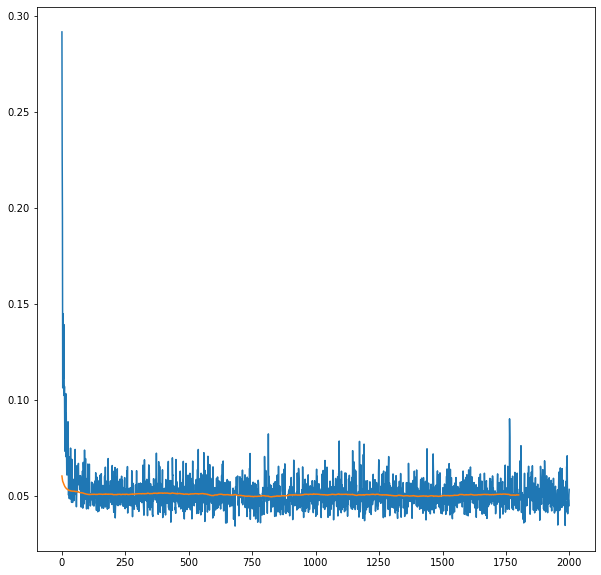

iteration: 2500, loss: tensor(0.0448, grad_fn=<MeanBackward0>)


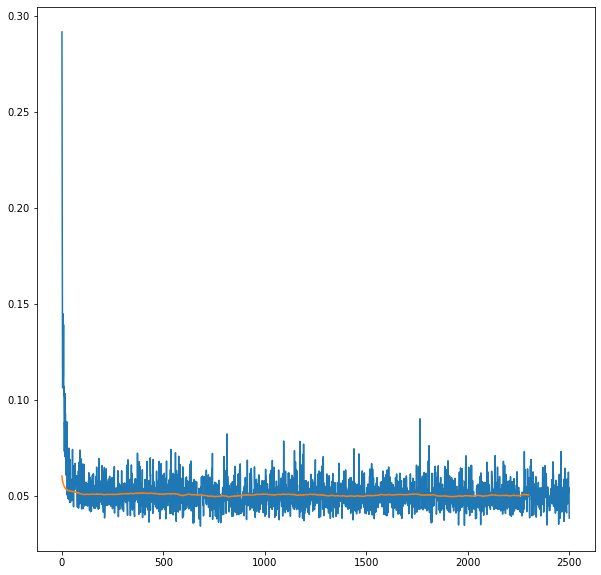

iteration: 3000, loss: tensor(0.0466, grad_fn=<MeanBackward0>)


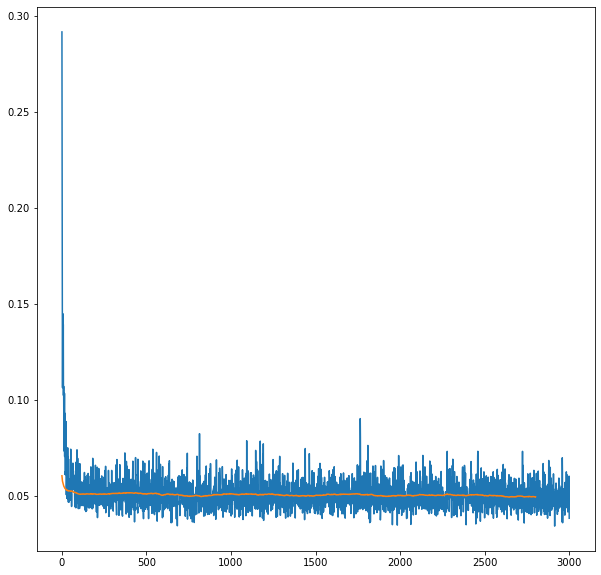

iteration: 3500, loss: tensor(0.0585, grad_fn=<MeanBackward0>)


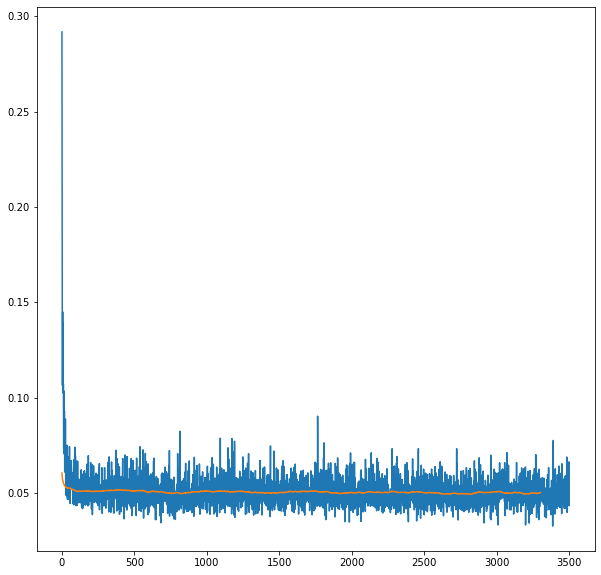

iteration: 4000, loss: tensor(0.0436, grad_fn=<MeanBackward0>)


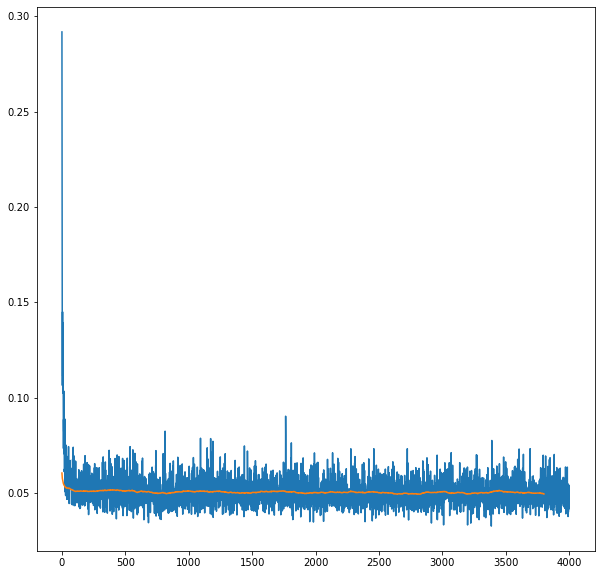

iteration: 4500, loss: tensor(0.0449, grad_fn=<MeanBackward0>)


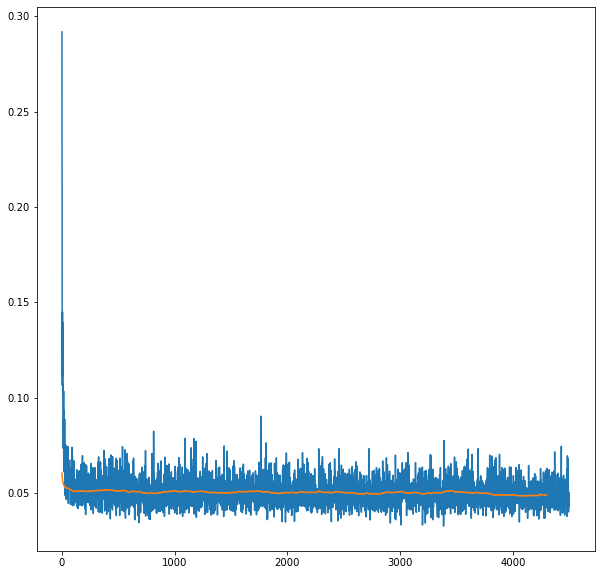

iteration: 5000, loss: tensor(0.0492, grad_fn=<MeanBackward0>)


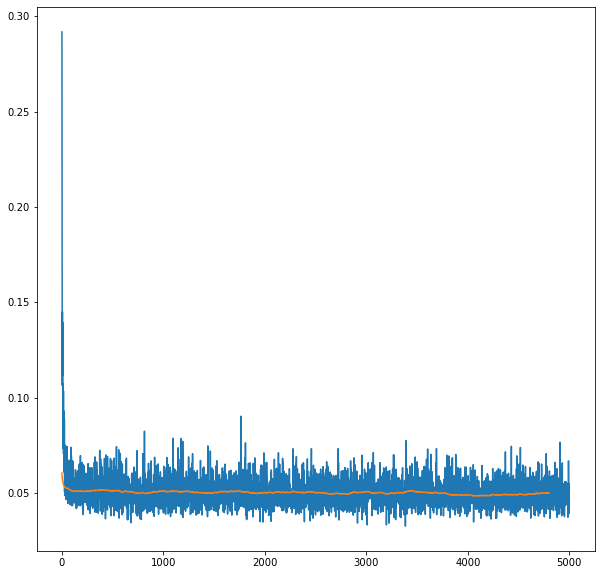

In [61]:
steps = 5000 #we run for 5000 steps
loss_vec = torch.zeros(steps) #this loss_vec tracks the loss over each iteration so we can plot it

#this defines the optimiser, note how the parameters are the transforms
optimizer = torch.optim.Adam(transform.parameters(), lr=5e-3) 

for i in range(steps):
    optimizer.zero_grad() #we call this on each iteration to reset the gradients
    
    #we sample 500 times per SGD iteration, this makes it quite slow, this is not necessary just use 100 say
    base_dist_samps = base_dist.sample(torch.Size([500,]))
    samps = flow_dist.transforms[0](base_dist_samps)
    
    loss = loss_KSD(samps, banana_test,0.1)
    loss.backward()
    
    optimizer.step()
    
    loss_vec[i] = loss.clone().detach() 
    
    flow_dist.clear_cache()
    
    if (i+1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200,2) 
        plt.show()

It looks like it worked!

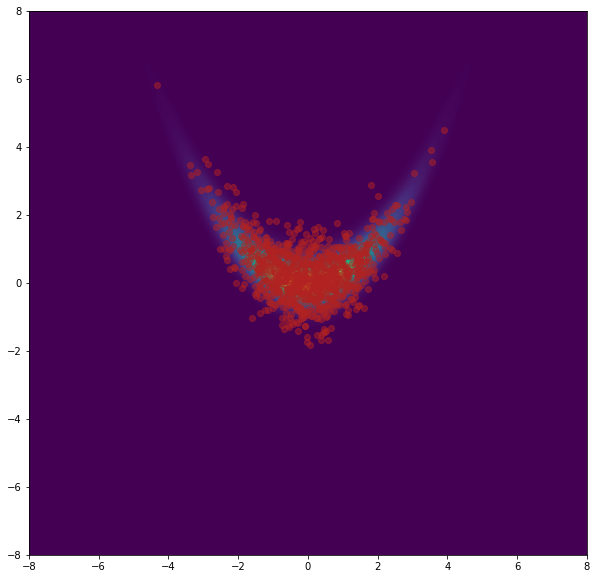

In [62]:
plot_banana(a,v1,v2,1000)

t_test = flow_dist.sample(torch.Size([1000,]))
t_test = t_test.detach().numpy() #in order to plot samples I need to cast them to numpy from pytorch
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1],color='firebrick',alpha=0.5)

plt.show()

### Sinusoidal density

In [63]:
a = 1.1
v1 = 2
v2 = 0.3

sinusoidal_test = lambda x: score_sinusoidal(x,a,v1,v2)

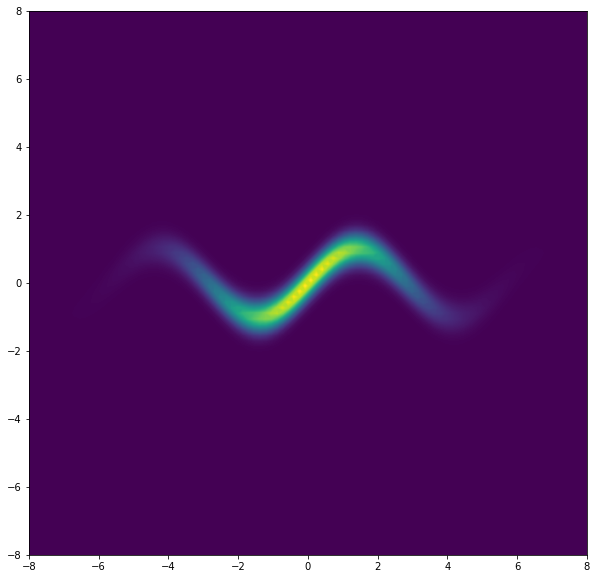

In [64]:
plot_sinusoidal(a,v1,v2,1000)

In [65]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
transform = T.AffineAutoregressive(AutoRegressiveNN(2, [80])) #we use the same type of transform as before 
flow_dist = dist.TransformedDistribution(base_dist, [transform]) #note that I overwrote the flow_dist variable here from before

iteration: 500, loss: tensor(0.3728, grad_fn=<MeanBackward0>)


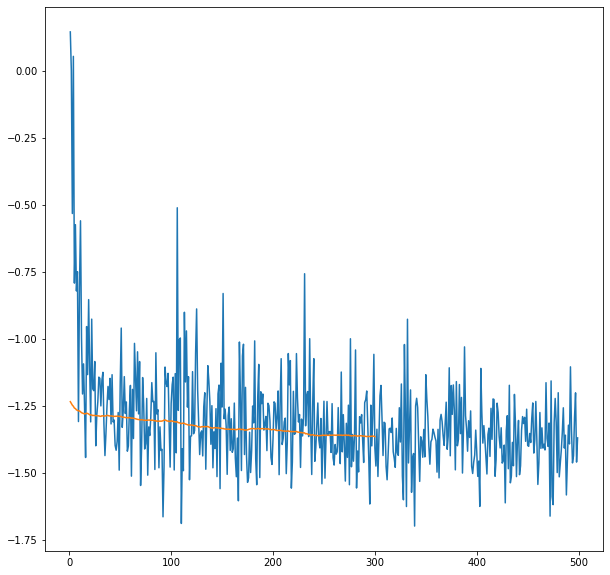

iteration: 1000, loss: tensor(0.3160, grad_fn=<MeanBackward0>)


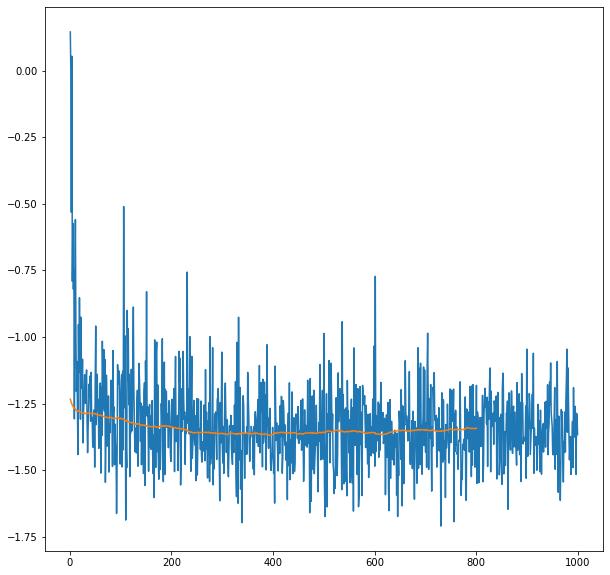

iteration: 1500, loss: tensor(0.3275, grad_fn=<MeanBackward0>)


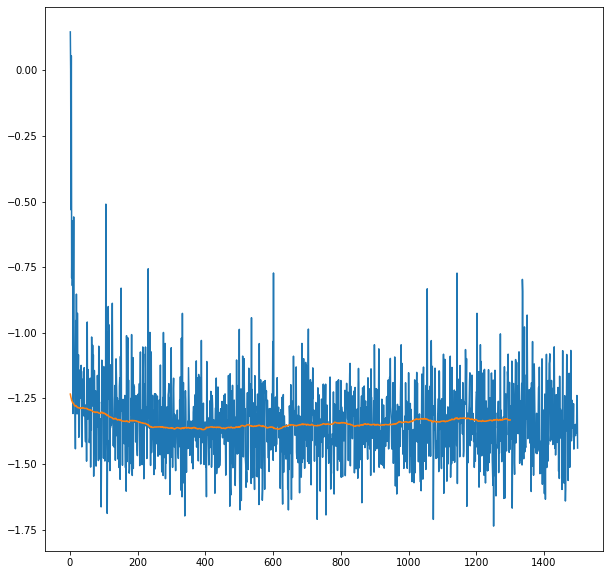

iteration: 2000, loss: tensor(0.2821, grad_fn=<MeanBackward0>)


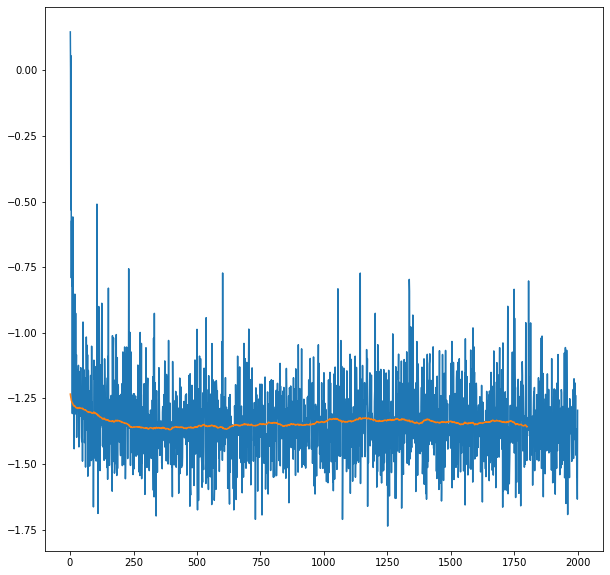

iteration: 2500, loss: tensor(0.3657, grad_fn=<MeanBackward0>)


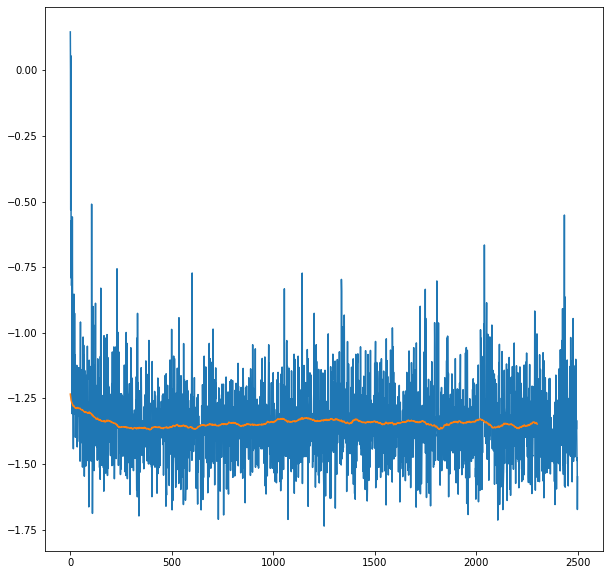

iteration: 3000, loss: tensor(0.2147, grad_fn=<MeanBackward0>)


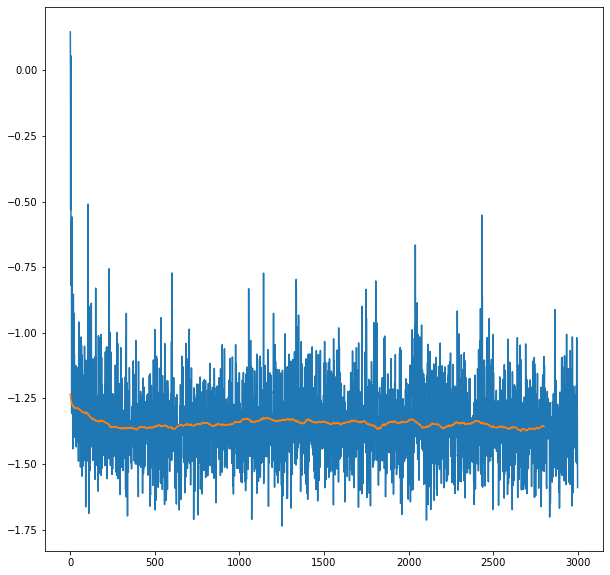

iteration: 3500, loss: tensor(0.2279, grad_fn=<MeanBackward0>)


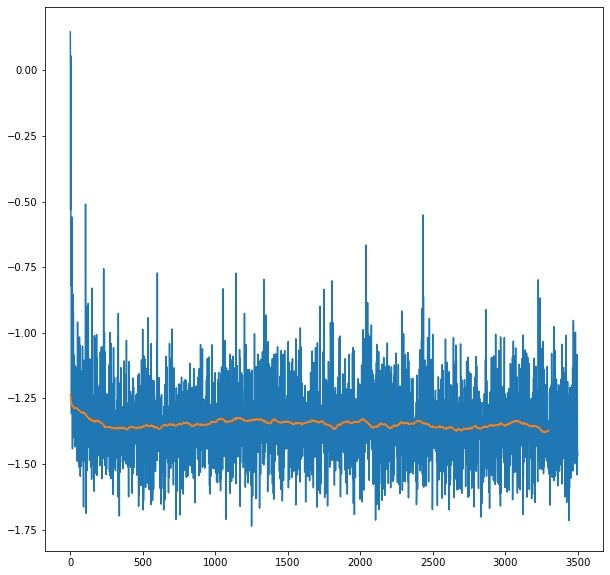

iteration: 4000, loss: tensor(0.2509, grad_fn=<MeanBackward0>)


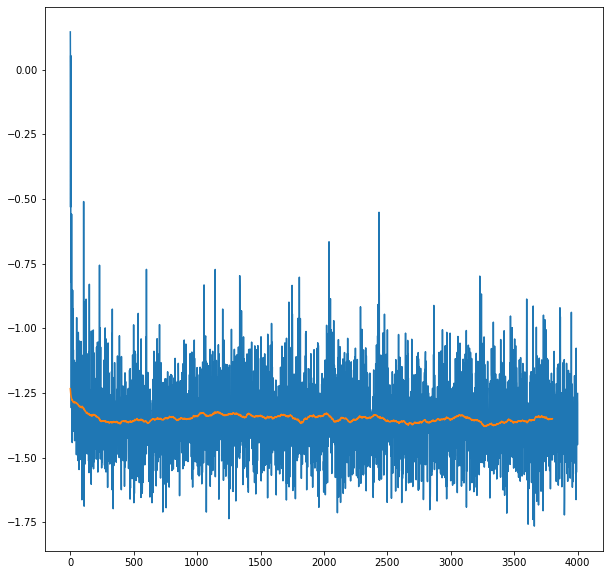

iteration: 4500, loss: tensor(0.2312, grad_fn=<MeanBackward0>)


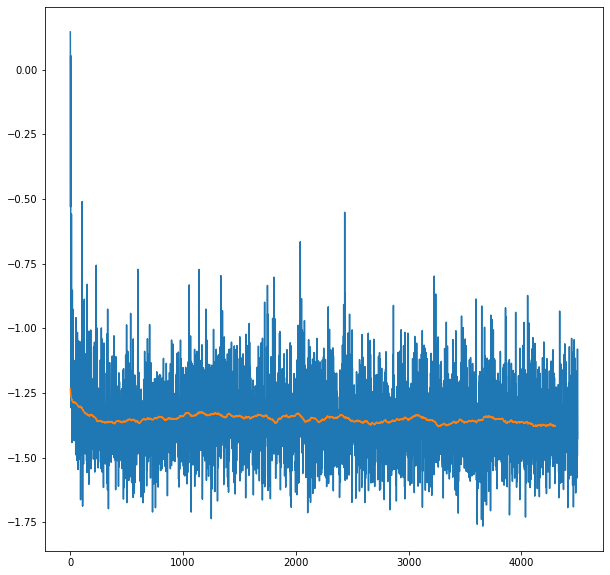

iteration: 5000, loss: tensor(0.2483, grad_fn=<MeanBackward0>)


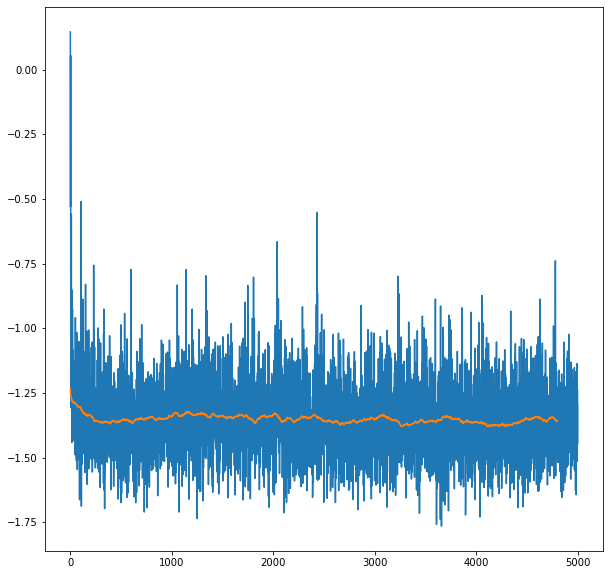

In [66]:
steps = 5000
loss_vec = torch.zeros(steps)

optimizer = torch.optim.Adam(transform.parameters(), lr=5e-3)

for i in range(steps):
    optimizer.zero_grad()
    base_dist_samps = base_dist.sample(torch.Size([100,]))
    samps = flow_dist.transforms[0](base_dist_samps)
    
    loss = loss_KSD(samps, sinusoidal_test,0.1)
    loss.backward()
    
    optimizer.step()
    
    loss_vec[i] = torch.log(loss.clone().detach()) #I am now plotting the log error
    
    flow_dist.clear_cache()
    
    if (i+1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200,2)
        plt.show()

It looks like it worked again, however the tails of the distribution are missing...

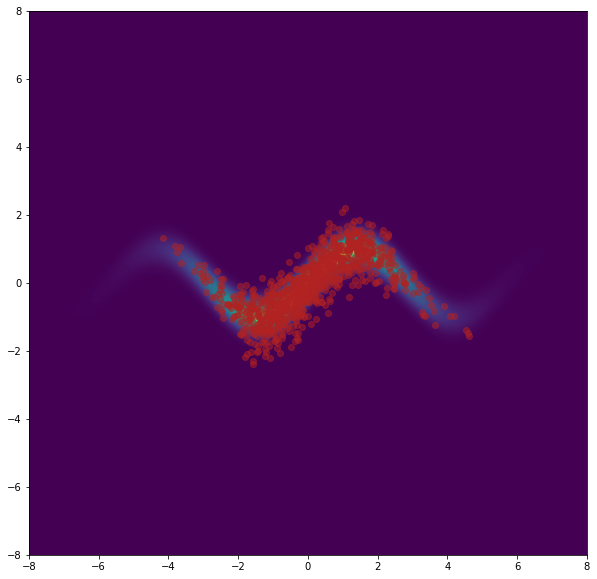

In [67]:
plot_sinusoidal(a,v1,v2,1000)

t_test = flow_dist.sample(torch.Size([1000,]))
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1],color='firebrick',alpha=0.5)
plt.ylim(-8,8)
plt.xlim(-8,8)

plt.show()

#### NVP (Affine coupling) Dennis
This is just using a different transform on the previous sinousoidal example. It attempts to recreate the transform used by Dennis in his paper Distilling importance sampling https://arxiv.org/abs/1910.03632.

In [68]:
from pyro.nn import DenseNN

input_dim = 2
split_dim = 1
param_dims = [input_dim-split_dim, input_dim-split_dim]

hypernet = DenseNN(split_dim, [10*input_dim], param_dims)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
transform = T.AffineCoupling(split_dim, hypernet)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

iteration: 500, loss: tensor(0.2554, grad_fn=<MeanBackward0>)


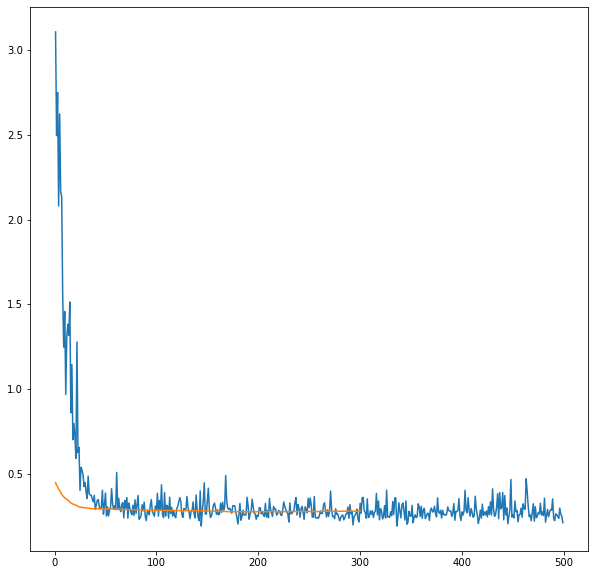

iteration: 1000, loss: tensor(0.2283, grad_fn=<MeanBackward0>)


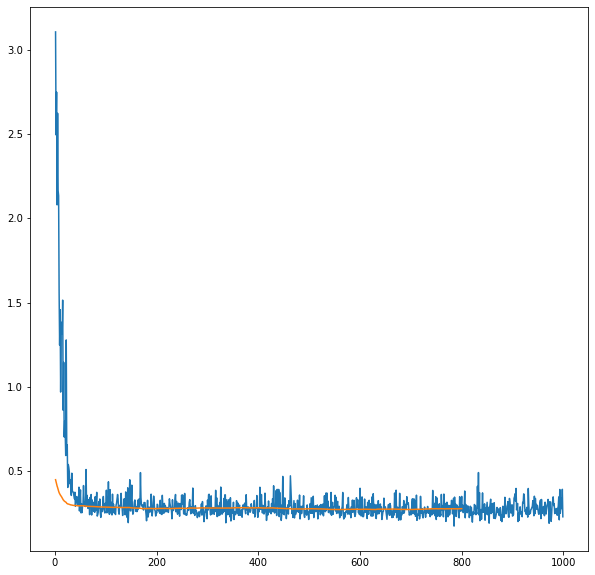

iteration: 1500, loss: tensor(0.3129, grad_fn=<MeanBackward0>)


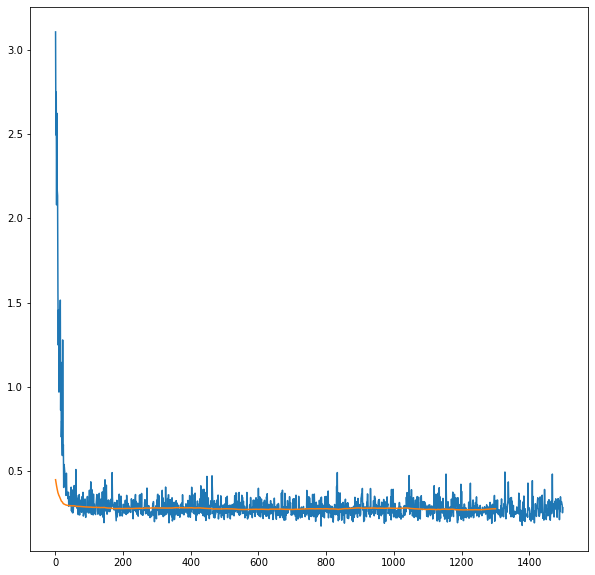

iteration: 2000, loss: tensor(0.2195, grad_fn=<MeanBackward0>)


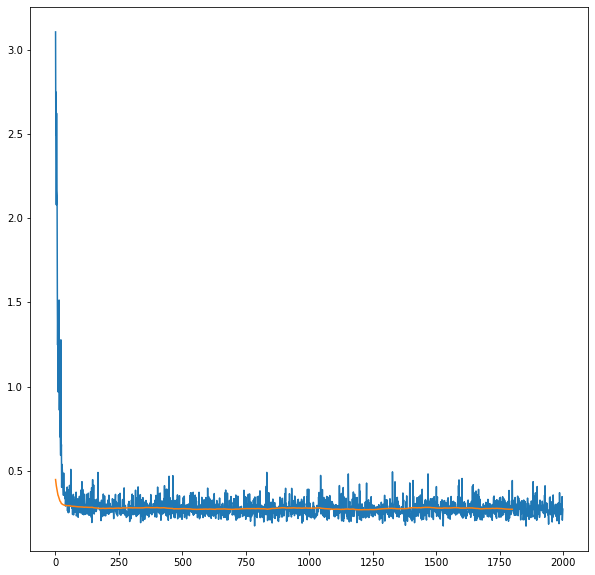

iteration: 2500, loss: tensor(0.2048, grad_fn=<MeanBackward0>)


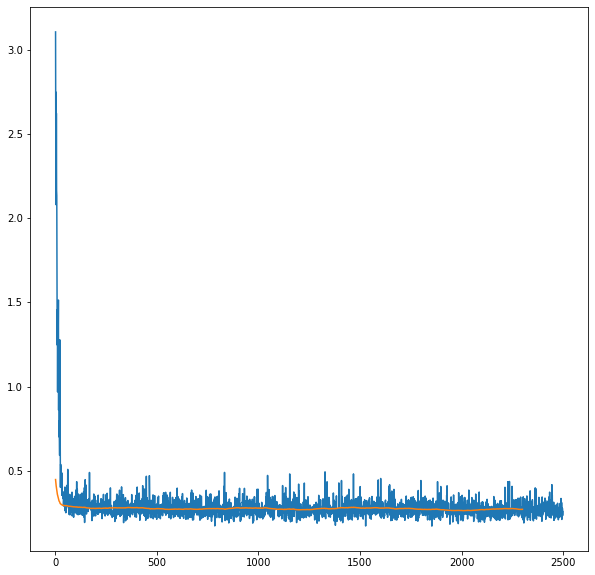

iteration: 3000, loss: tensor(0.2529, grad_fn=<MeanBackward0>)


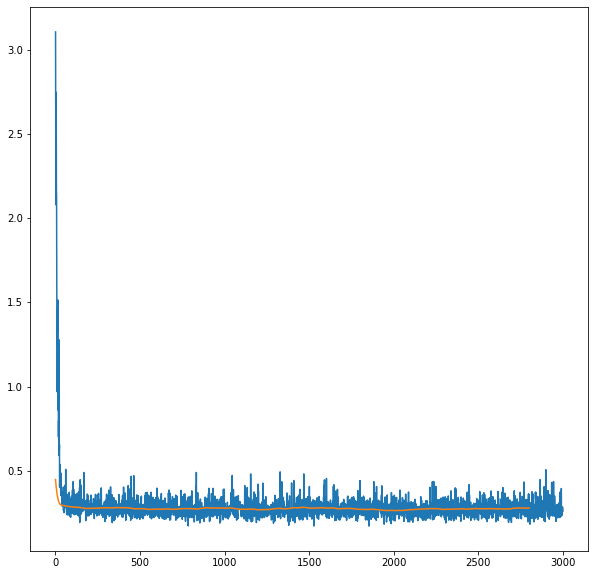

iteration: 3500, loss: tensor(0.2497, grad_fn=<MeanBackward0>)


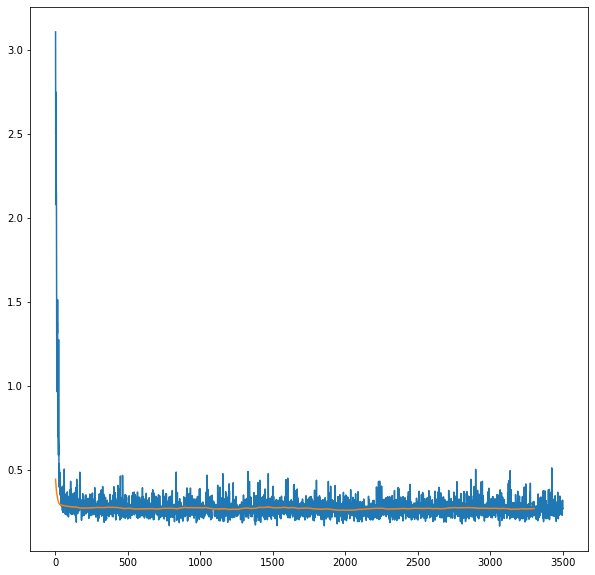

iteration: 4000, loss: tensor(0.3004, grad_fn=<MeanBackward0>)


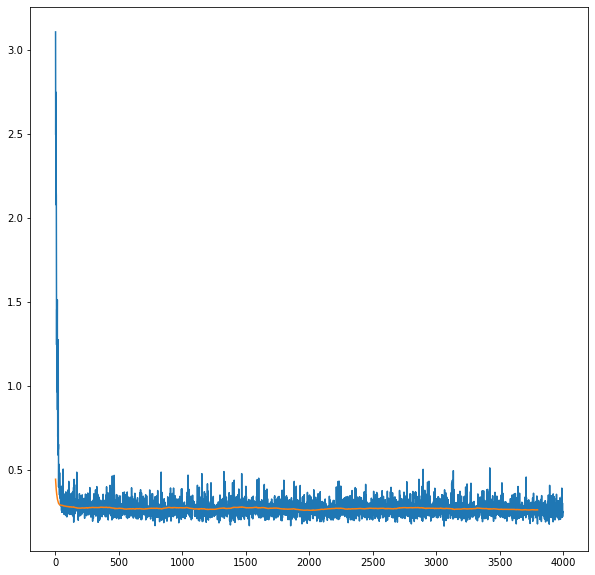

iteration: 4500, loss: tensor(0.4314, grad_fn=<MeanBackward0>)


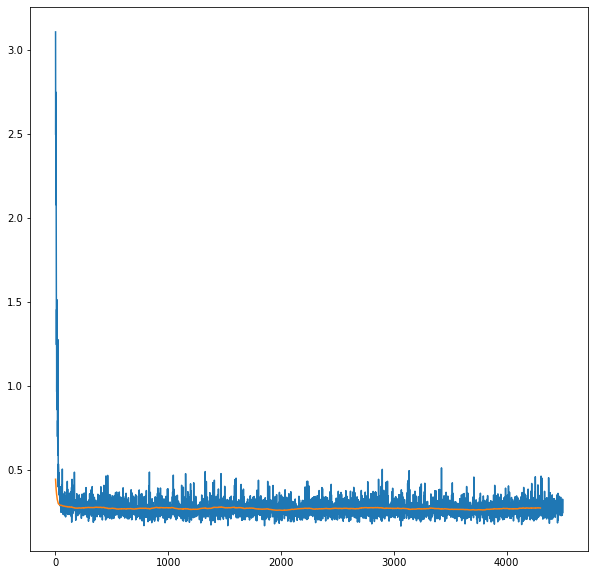

iteration: 5000, loss: tensor(0.3214, grad_fn=<MeanBackward0>)


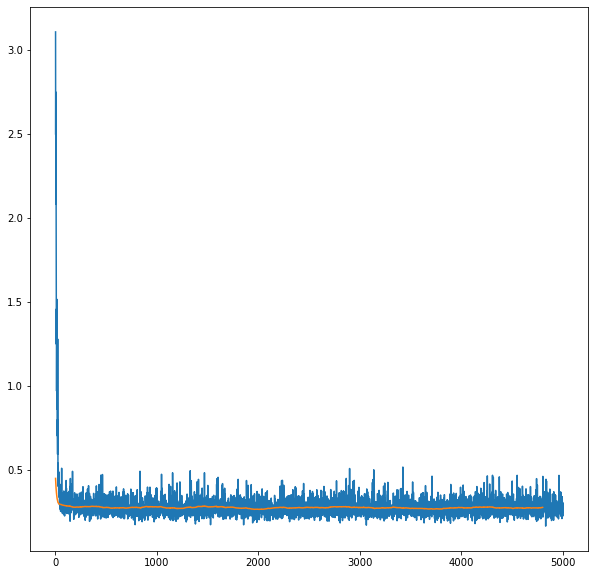

iteration: 5500, loss: tensor(0.2249, grad_fn=<MeanBackward0>)


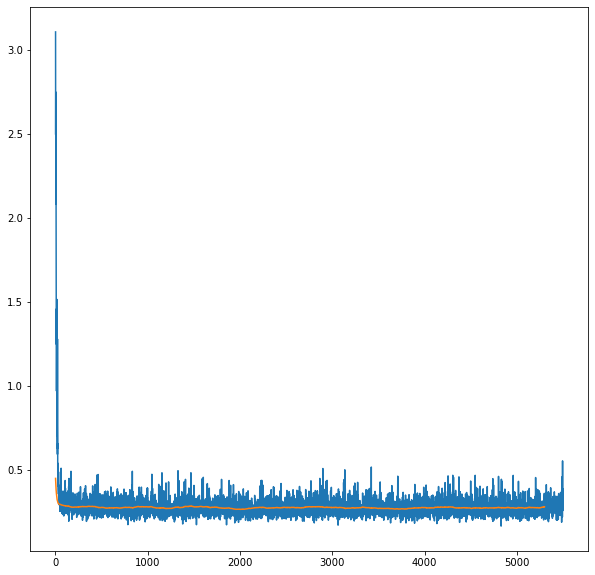

iteration: 6000, loss: tensor(0.2261, grad_fn=<MeanBackward0>)


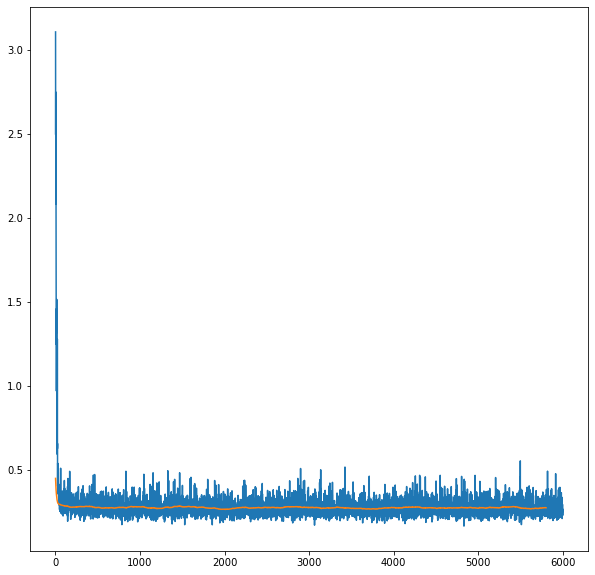

iteration: 6500, loss: tensor(0.2243, grad_fn=<MeanBackward0>)


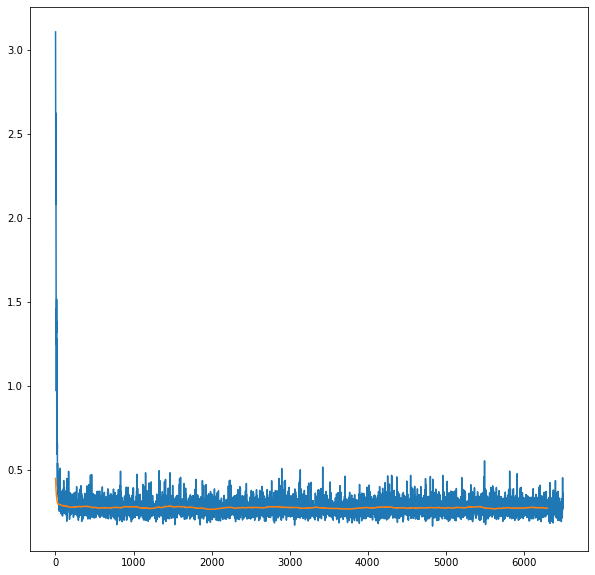

iteration: 7000, loss: tensor(0.2858, grad_fn=<MeanBackward0>)


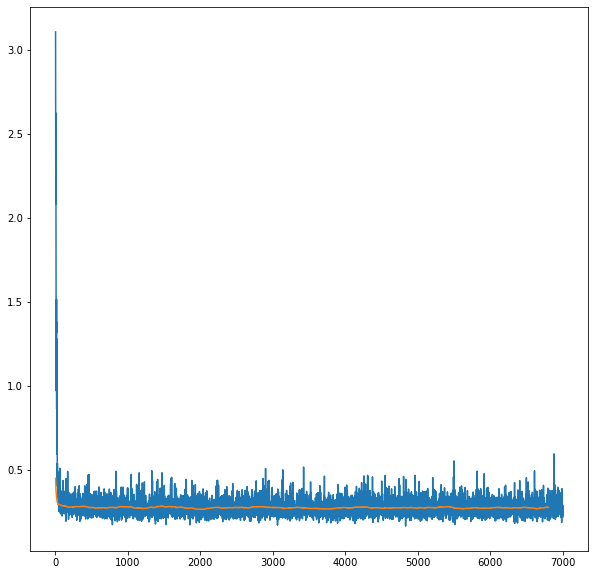

iteration: 7500, loss: tensor(0.2177, grad_fn=<MeanBackward0>)


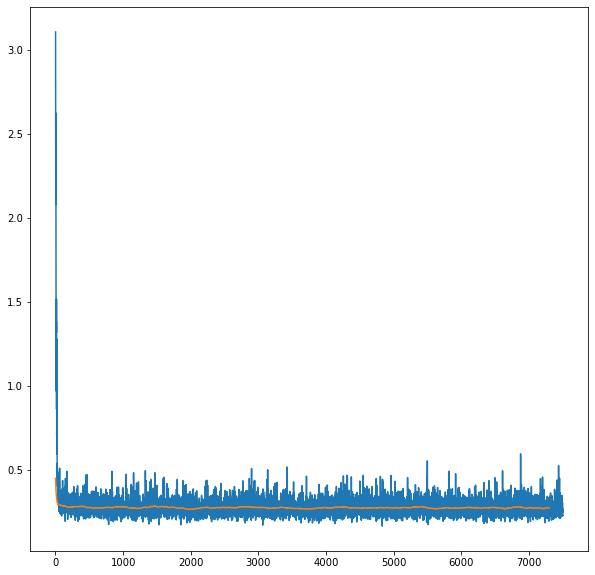

iteration: 8000, loss: tensor(0.3014, grad_fn=<MeanBackward0>)


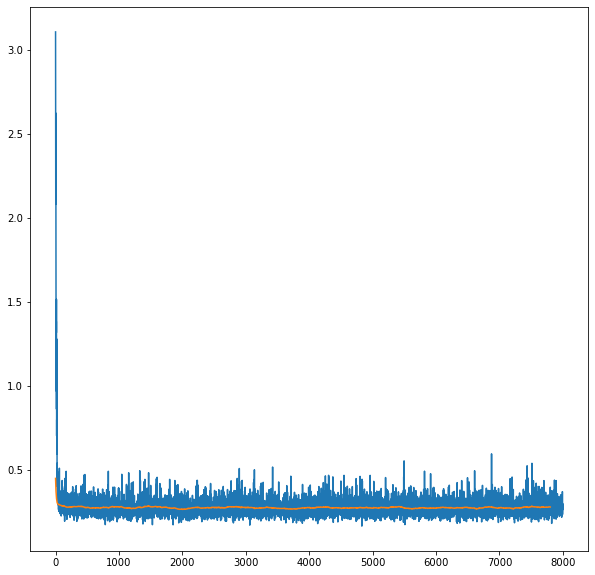

iteration: 8500, loss: tensor(0.3466, grad_fn=<MeanBackward0>)


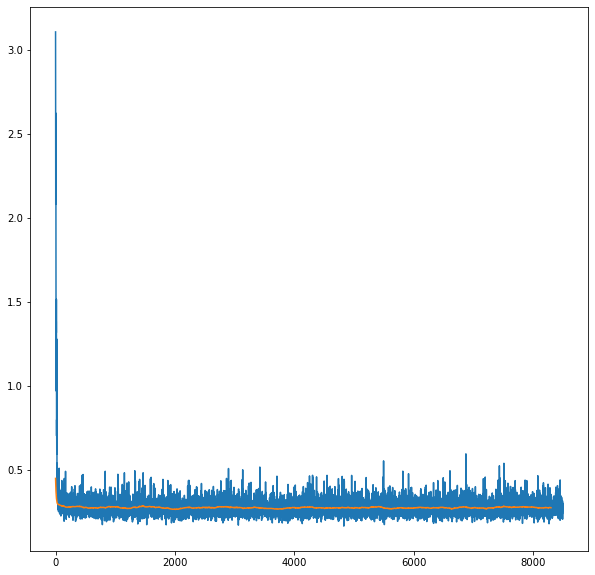

iteration: 9000, loss: tensor(0.2520, grad_fn=<MeanBackward0>)


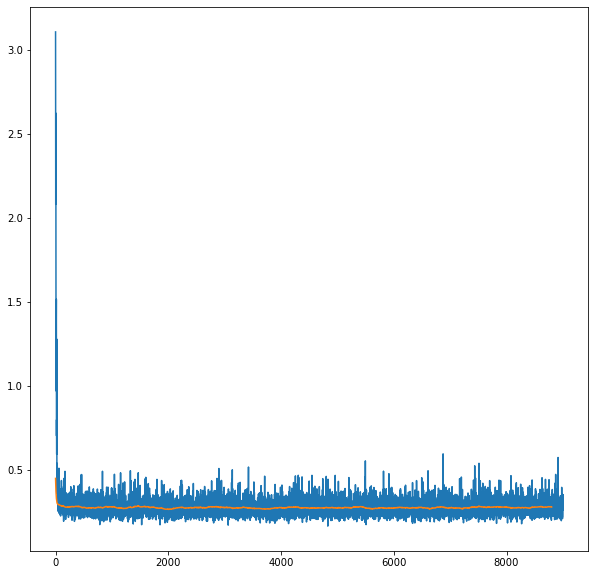

iteration: 9500, loss: tensor(0.2570, grad_fn=<MeanBackward0>)


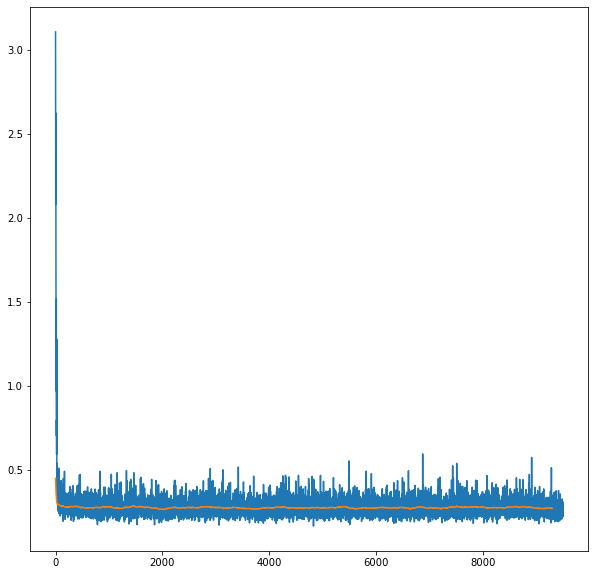

iteration: 10000, loss: tensor(0.2028, grad_fn=<MeanBackward0>)


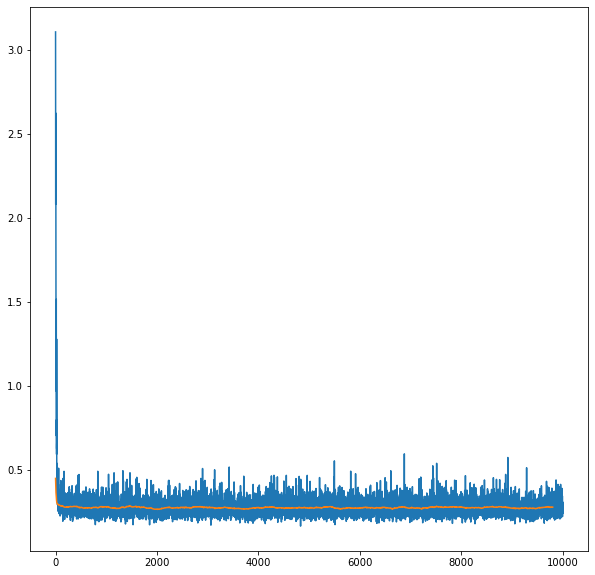

In [69]:
steps = 10000
loss_vec = torch.zeros(steps)

optimizer = torch.optim.Adam(transform.parameters(), lr=5e-3)

for i in range(steps):
    optimizer.zero_grad()
    base_dist_samps = base_dist.sample(torch.Size([100,]))
    samps = flow_dist.transforms[0](base_dist_samps)
    
    loss = loss_KSD(samps, sinusoidal_test,0.1)
    loss.backward()
    
    optimizer.step()
    
    loss_vec[i] = loss.clone().detach() #I am not plotting the log of the loss anymore
    
    flow_dist.clear_cache()
    
    if (i+1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200,2)
        plt.show()

It looks like it worked, however 

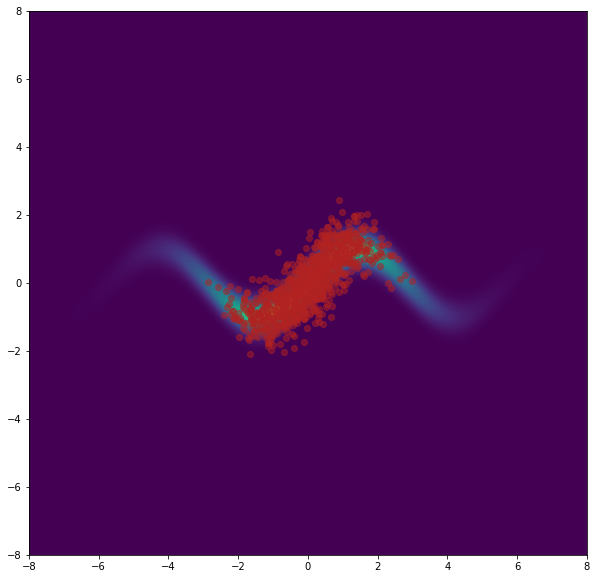

In [73]:
plot_sinusoidal(a,v1,v2,1000)

t_test = flow_dist.sample(torch.Size([1000,]))
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1],color='firebrick',alpha=0.5)


plt.show()